# TD3 - Apprentissage par renforcement

**L’objectif de ce TD** est de mettre en oeuvre l’apprentissage par renforcement. Nous allons
utiliser le toolkit Gym qui propose plusieurs types d’environnements de simulation. Nous nous intéresserons en particulier à l’environnement Cartpole et à celui du jeu Breakout d’Atari.

L'apprentissage par renforcement consiste, pour un agent autonome (robot, etc.), à apprendre les actions à prendre, à partir d'expériences, de façon à optimiser une récompense au cours du temps. 

L'agent est plongé au sein d'un environnement, et prend ses décisions en fonction de son état courant. En retour, l'environnement procure à l'agent une récompense, qui peut être positive ou négative. L'agent cherche, au travers d'expériences itérées, une stratégie optimale, c'est à dire qui maximise la somme des récompenses au cours du temps.

On effectuera ce TP via Google colab afin de profiter des GPU proposées. 
On installe donc les librairies nécessaires suivantes pour tout le TP notamment pur l'environnement Breakout

In [1]:
!apt-get install -y xvfb python-opengl x11-utils
!pip install gym==0.17.2 pyvirtualdisplay==0.2.5

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
python-opengl is already the newest version (3.1.0+dfsg-1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [2]:
# Télécharge les différentes 'ROMS', qui contiennent les jeux Atari. On a donc accès ici à tous les jeux Atari.N
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2022-01-17 08:52:48--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar.1’

Roms.rar.1          100%[===================>]  10.61M   487KB/s    in 23s     

2022-01-17 08:53:11 (470 KB/s) - ‘Roms.rar.1’ saved [11128004/11128004]

mkdir: cannot create directory ‘/content/ROM/’: File exists

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar


Would you like to replace the existing file /content/ROM/HC ROMS.zip
11826711 bytes, modified on 2019-12-22 11:24
with a new one
11826711 bytes, modified on 2019-12-22 11:24

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Y

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 

Would you like to 

In [3]:
pip install gym[atari,accept-rom-license]

In [4]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [5]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

## Premier cas d'application : le CartPole

**CartPole**, également connu sous le nom de pendule inversé, est un jeu dans lequel vous essayez d'équilibrer une perche le plus longtemps possible. On suppose qu'à l'extrémité de la perche, il y a un objet qui la rend instable et très susceptible de tomber. Le but de cette tâche est de déplacer le chariot de gauche à droite de manière à ce que le poteau puisse rester en équilibre (dans un certain angle) le plus longtemps possible.

On commence par importer les différents modules nécessaires à ce TD. Le module gym possède de nombreux environnements permettant d'entraîner des modèles de Reinforcement Learning.
On utilise des modules plus commun comme matplotlib, Image, torch respectivement pour les parties affichages, traitement d'image et computationnelle.

In [6]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# Si accès à un GPU, on indique à torch de le faire tourner sur le GPU (plus puissant).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from IPython import display as ipythondisplay
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [7]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

print(Transition(state=3, action=1, next_state=6, reward=0))
print(Transition(1, 1, 1, 1))
print(Transition([1,2,3], [4,5,6], [1,2,3], [7,8,9]))

Transition(state=3, action=1, next_state=6, reward=0)
Transition(state=1, action=1, next_state=1, reward=1)
Transition(state=[1, 2, 3], action=[4, 5, 6], next_state=[1, 2, 3], reward=[7, 8, 9])


### ReplayMemory

Cette classe permet de rejouer la mémoire afin d'effectuer le nouveau mouvement du chariot. les fonctions sont l'initialisation, l'addition de la nouvelle position du chariot, le renvoie de la longueur de la mémoire, l'échantillonnage d'un batch de la mémoire.

In [8]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### QNet
On définit la classe QNet. QNet est un réseau avec une couche cachée, prise ici par défaut avec 256 neurones. On implémente également la fonction forward, qui nous permet d'effectuer la forward propagation dans le réseau. On fait le choix de mettre la dimension d'entrée et de sortie du QNet en argument, pour un programme plus adaptatif.

le Q-learning est une technique d'apprentissage par renforcement. Cette technique ne nécessite aucun modèle initial de l'environnement. La lettre 'Q' désigne la fonction qui mesure la qualité d'une action exécutée dans un état donné du système.

Cette méthode fonctionne par l'apprentissage d'une fonction notée Q(s,a) qui permet de déterminer le gain potentiel, c'est-à-dire la récompense sur le long terme, apportée par le choix d'une certaine action "a" dans un certain état "s" en suivant une stratégie optimale. Lorsque cette fonction Q est connue ou apprise par l'agent, la stratégie optimale peut être construite en sélectionnant l'action à valeur maximale pour chaque état, c'est-à-dire en sélectionnant l'action a qui maximise la valeur Q(s,a) quand l'agent se trouve dans l'état s.

Dans un environnement reinforcement learning, pour un état (S) et une action (A), il y aura une valeur Q associée qui est maintenue dans une table. Mais lorsque le nombre d'états possibles est trop important, les valeurs Q associées à ces paires état-action explosent en nombre. C'est pourquoi on peut remplacé cette table Q par une fonction comme un réseau de neurones profond. D'où le nom de Deep-Q-Learning.

In [9]:
class QNet(nn.Module):

    def __init__(self, dim_in, dim_out, fc_size=256):
        super(QNet, self).__init__()
        # Définition d'un réseau avec une couche cachée (à 256 neurones par exemple)
        # Linear crée une couche de 'Fully Connected Layers'
        self.fc1 = nn.Linear(in_features=dim_in, out_features=fc_size) # Number of input = Number of output de la couche précédente
        self.out = nn.Linear(in_features=fc_size, out_features=dim_out) # Number of output 2 car seulement 2 actions possibles (droite ou gauche)
        

    def forward(self, x):
        # Calcul de la passe avant, avec ReLU pour fonction d'activation de la couche cachée
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        # Fonction d'activation linéaire sur la couche de sortie
        x = self.out(x)
        return x

### Agent 
Cette classe va permettre la gestion de l'agent (ici du chariot) afin de l'initialiser, de sélectionner l'action à effectuer ainsi que le processus d'entraînement du réseau de neurones. 

Ensuite, on implémente plusieurs fonctions : 
- initialisation : On initialise tous les paramètres de l'agent, les paramètres d'entraînement, les paramètres de sélection d'une action et l'initialisation du réseau de neurones. Le seul argument ici est l'environnement.
- selection d'action: On décide dans cette fonction si l'on va utiliser l'action prédite ou si on réalise une action aléatoire. Ce choix se fait en fonction d'un seuil, si une valeur tirée aléatoirement entre 0 et 1 est supérieure au seuil défini alors on sélectionne l'action renvoyée par la stratégie (le réseau de neurones) qui a le meilleur score. Sinon on renvoie une action aléatoire. Le seul argument ici est l'état du chariot.

- optimisation du modèle: Dans cette fonction on va optimiser les paramètres du réseau de neurones. Le déroulement est le suivant: à partir d'un batch d'un triplet donné : state, action, reward (pris dans dans le tuple: Transition stockant tous ces triplets plus le next\_state), on va d'abord calculer Q pour l'état courant à partir state et action dans le triplet précédent. On calcule ensuite Q prédit de l'état suivant. Enfin on calcul le Q cumulé attendu à partir du Q prédit que l'on vient de calculer et de la reward de l'état actuel, ce cumulé correspondant à l'état attendu. On utilise ensuite la perte de huber et on compare Q prédit et Q cumulé puis on optimise le sparamètres du réseau de neurones via une descente de gradient.

- train policy modèle: Ici on réalise la fonction l'entraînement du réseau de neurones sur tous les épisodes. 

- test : Ici on va sélectionner l'action à faire à chaque épisode et l'envoyer à l'environnement afin de visualiser l'action.

- Affichage de l'apprentissage : On obtient 2 graphes :
    - Un graphe affichant la durée de l'épisode en fonction du nombre d'épisodes passés. L'apprentissage dans le problème du cartPole a pour buter de maximiser le temps sans que la barre tombe. La mesure de la durée de l'épisode est donc une bonne mesure de la performance de l'algorithme.
    - Un graphe représentant la **moyenne** glissante des durées des épisodes (sur 100 épisodes). La moyenne glissante est plus pertinente pour observer l'apprentissage car la durée sur un simple épisode peut varier fortement du fait de la parite d'exploration de agent.

Le process global est le suivant :
1. On initialise la replay memory.
2. On initialise le policy network avec des poids aléatoires.
3. On clone le policy network, et on l'appelle le target network.
4. Pour chaque épisode:
    1. On initialise l'état de départ.
    2. Pour chaque pas de temps:
        1. On sélectionne une action.
             - Via exploration ou exploitation (epsilon-greedy strategy)
        2. On exécute l'action selectionnée.
        3. On observe la récompense obtenue et le prochain état (next state).
        4. On stocke l'expérience dans la replay memory.
        5. On pioche aléatoirement un batch dans replay memory.
        6. On preprocess les états des éléments du batch.
        7. On passe le batch des états préprocessés au policy network.
        8. On calcule la fonction de perte de Huber entre les Q-values prédites et Q-values voulues (target).
            - Cela nécessite une passe à travers le target network pour le next state
        9. On utilise une descente de gradient pour mettre à jour les weights dans le policy network afin de minimiser la fonction de perte.
            - Après les différents pas de temps, les poids dans le target network sont mis à jour en prenant les poids du policy network.



In [10]:
class Agent:
    def __init__(self,env, num_episodes=500, num_episodes_test=100):
        self.env = env
        self.batch_size = 128
        self.gamma = 0.999
        self.eps_start = 0.9
        self.eps_end = 0.05
        self.eps_decay = 200
        self.target_update = 10
        self.num_episodes = num_episodes
        self.num_episodes_test = num_episodes_test
        self.n_actions = env.action_space.n
        self.episode_durations = []

        # Dimension d'entree et de sortie du reseau
        observation_space, action_space = env.observation_space.shape[0], env.action_space.n
        self.policy_net = QNet(observation_space, action_space).to(device)
        self.target_net = QNet(observation_space, action_space).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = ReplayMemory(10000)

        self.steps_done = 0

    def select_action(self,state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
            math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold: # Exploitation
            # Calcul et renvoi de l'action fournie par le réseau
            return self.policy_net.forward(state).max(1)[1].view(1, 1)
        else: # Exploration
            # Calcul et renvoi d'une action choisie aléatoirement
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

    def process_state(self,state):
        return torch.from_numpy(state).unsqueeze(0).float().to(device)

    def plot_durations(self, is_testing=False):
        if is_ipython:
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

        plt.figure(2)
        plt.clf()
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if is_testing:
            plt.suptitle('Testing...')
        else:
            plt.suptitle('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.subplot(121)
        plt.plot(durations_t.numpy(), color='b')

        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.subplot(122)
            plt.plot(means.numpy(), color='m')

        plt.pause(0.001)  # pause a bit so that plots are updated
        
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)

        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.uint8)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Calcul de Q(s_t,a) : Q pour l'état courant
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Calcul de Q pour l'état suivant
        next_state_values = torch.zeros(self.batch_size, device=device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        
        # Calcul de Q future attendue cumulée
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Calcul de la fonction de perte de Huber
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimisation du modèle
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        

    def train_policy_model(self):

        for i_episode in range(self.num_episodes):
            state = self.env.reset()

            for t in count():

                action = self.select_action(self.process_state(state))
                next_state, reward, done, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=device)

                if done:
                    next_state = None

                self.memory.push(self.process_state(state), action, self.process_state(next_state) if not next_state is None else None, reward)

                state = next_state

                self.optimize_model()

                if done:
                    self.episode_durations.append(t + 1)
                    if i_episode > 0 and i_episode % 50 == 0:
                        self.plot_durations()
                    break

            if i_episode % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                self.save_model()

        self.save_model()
        print('Training completed')
        plt.show()


    def save_model(self):
        torch.save(self.policy_net.state_dict(), "./qlearning_model")

    def load_model(self):
        self.policy_net.load_state_dict(torch.load("./qlearning_model", map_location=device))

    def test(self, is_visible=True, is_random=False):
        print('Testing model:')
        self.episode_durations = []
        for i_episode in range(self.num_episodes_test):
            print('episode: {}'.format(i_episode))
            state = self.env.reset()
            for t in count():
                if is_visible:
                    screen = self.env.render(mode='rgb_array')
                    plt.imshow(screen)
                    ipythondisplay.clear_output(wait=True)
                    ipythondisplay.display(plt.gcf())
                    
                # Sélection d'une action appliquée à l'environnement
                action = None
                if is_random:
                    action = torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)
                else:
                    action = self.policy_net.forward(self.process_state(state)).max(1)[1].view(1, 1)
                # et mise à jour de l'état
                next_state, reward, done, _ = self.env.step(action.item())
                if done:
                    next_state = None
                self.memory.push(self.process_state(state), action, self.process_state(next_state) if not next_state is None else None, reward)
                if done:
                    self.episode_durations.append(t + 1)
                    if i_episode > 0 and i_episode % 50 == 0:
                        self.plot_durations(is_testing=True)
                    print("Episode finished after {} timesteps".format(t+1))
                    break
                state = next_state

        print('Testing completed')

### Main loop
Définition de l'environnement et de l'agent.

In [11]:
env = gym.make('CartPole-v0').unwrapped
env.reset()

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

agent = Agent(env, num_episodes=2000, num_episodes_test=100)

On entraîne cet agent. On observe les résulats de l'entraînement sur les graphes ci-dessous. 

Etant donné l'augmentation du temps entre chaque épisode l'entraînement de l'agent semble s'être correctement effectué.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

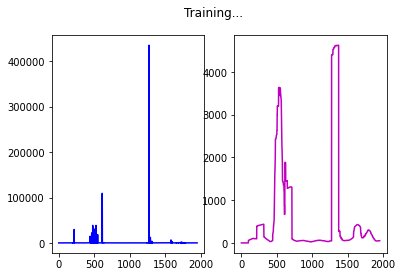

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)


Training completed


In [12]:
# Training phase
agent.train_policy_model()

On teste l'agent entrainé et on observe les résultats sur l'interface de CartPole. 

A ce moment nous sommes dans la phase d'exploitation il n'y a plus d'exploration de la part de l'agent.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

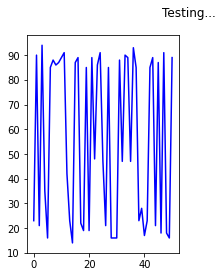

Episode finished after 89 timesteps
episode: 51
Episode finished after 21 timesteps
episode: 52
Episode finished after 86 timesteps
episode: 53
Episode finished after 40 timesteps
episode: 54
Episode finished after 85 timesteps
episode: 55
Episode finished after 14 timesteps
episode: 56
Episode finished after 89 timesteps
episode: 57
Episode finished after 45 timesteps
episode: 58
Episode finished after 90 timesteps
episode: 59
Episode finished after 88 timesteps
episode: 60
Episode finished after 86 timesteps
episode: 61
Episode finished after 90 timesteps
episode: 62
Episode finished after 90 timesteps
episode: 63
Episode finished after 89 timesteps
episode: 64
Episode finished after 14 timesteps
episode: 65
Episode finished after 24 timesteps
episode: 66
Episode finished after 23 timesteps
episode: 67
Episode finished after 90 timesteps
episode: 68
Episode finished after 86 timesteps
episode: 69
Episode finished after 16 timesteps
episode: 70
Episode finished after 19 timesteps
epis

In [13]:
agent.load_model()
agent.test(is_visible=False)

On va comparer les résultats obtenus avec un agent naïf aléatoire. 

On observe nettement différence entre les performances (Nombre de timesteps de chaque épisode) de l'agent entraîné et l'agent naïf ce qui montre que la stratégie choisie par l'agent est bénéfique.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

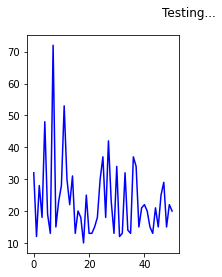

Episode finished after 20 timesteps
episode: 51
Episode finished after 54 timesteps
episode: 52
Episode finished after 27 timesteps
episode: 53
Episode finished after 22 timesteps
episode: 54
Episode finished after 14 timesteps
episode: 55
Episode finished after 17 timesteps
episode: 56
Episode finished after 23 timesteps
episode: 57
Episode finished after 42 timesteps
episode: 58
Episode finished after 15 timesteps
episode: 59
Episode finished after 15 timesteps
episode: 60
Episode finished after 11 timesteps
episode: 61
Episode finished after 16 timesteps
episode: 62
Episode finished after 11 timesteps
episode: 63
Episode finished after 14 timesteps
episode: 64
Episode finished after 11 timesteps
episode: 65
Episode finished after 13 timesteps
episode: 66
Episode finished after 16 timesteps
episode: 67
Episode finished after 12 timesteps
episode: 68
Episode finished after 58 timesteps
episode: 69
Episode finished after 24 timesteps
episode: 70
Episode finished after 24 timesteps
epis

In [14]:
#Random phase
agent.load_model()
agent.test(is_visible=False, is_random=True)

La représentation du Cart-Pole, et le nombre de steps réalisé pour un entrainement sur 1000 epochs.

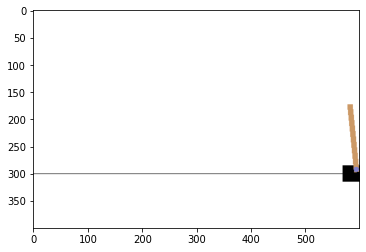

Episode finished after 92 timesteps
Testing completed


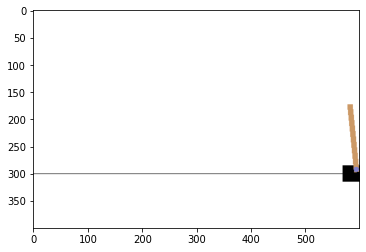

In [15]:
# Show representation of the cart-Pole
agent = Agent(env, num_episodes=1000, num_episodes_test=1)
agent.load_model()
agent.test(is_visible=True)

In [16]:
env.close()

## Deuxième cas d'application : le jeu Breakout


Breakout est un jeu d'arcade, commercialisé par Atari Inc. en 1976.

Dans Breakout, plusieurs lignes de « briques » sont alignées dans le haut de l'écran de jeu. Une balle traverse l’écran, rebondissant sur les côtés et le haut. Lorsque la balle touche une brique, elle rebondit et la brique disparaît. Le joueur possède une raquette qu'il peut déplacer latéralement afin de faire rebondir la balle vers le haut. Il perd une vie quand la balle touche le bas de l’écran.

Le contexte d'utilisation d'apprentissage par renforcement ici est qu'à partir d'une entré qui correspond à l'observation d'une séquence de 4 images consécutives afin d’avoir l’information de mouvement d'obtenir en sortie l'action à prendre, ie: se déplacer à gauche, à droite ou ne rien faire.

Pour effectuer cela on utilisera ici ce qu'on appelle un DQ-learning (Deep Q-learning) signifiant que l'on aura plusieurs couches au réseau de neurones basé sur un réseau convolutif afin de pouvoir traiter directement les images.

L'idée ici, est donc d'utiliser un Convolutionnal Neural Network (CNN) pour prendre en entrée les images du **jeu Breakout**, puis d'utiliser la sortie de ce CNN avec quelques couches de Fully Connected (FC) Layers, afin d'obtenir une décision sur l'action à prendre.

Nous allons voir comment nous avons tenté de mettre cela en place, et malgré les résultats médiocres et non fonctionnels obtenus le cheminement pour y arriver est intéressant et nous à amené à réfléchir sur l'intérèt de l'entrainement.

Premièrement, on importe des packages pour le traitement d'image du jeu Breakout. La conversion des images de RGB vers Gray (nuances de gris) permet de passer d'une image de format :
- height x width x 3 channels (R,G,B) 
- A height x width x 1 channel. 

On effectue ce **prétraitement car pour notre problème, on considère que les couleurs ont peu d'importance**, c'est surtout la position des éléments qui est primordiale (balle, briques, barre).
Cette **division par 3** de la dimension d'entrée permet de **réduire le nombre de paramètre** dans le premier Convolutional Layer, et donc **d'accélérer l'apprentissage** (la couleur n'étant pas importante ici).

In [17]:
# On importe ici des packages pour le traitement d'image du jeu Breakout
from skimage.transform import resize
from skimage.color import rgb2gray, rgba2rgb

## ReplayMemory
> Aucun changement par rapport à la première partie

## DQN
Implémentation du Deep Q Network.On a un CNN avec **3 couches de convolution** toute suivie d'une batch normalization, puis d'une **couche Fully Connected** donnant les outputs potentielles.

Les tailles de filtre et le pas étaient imposés. La fonction d'activation est ReLU (classique pour des couches convolutionnelles) et linéaires pour la couche fully connected.

In [18]:
class DQN(nn.Module):
    def __init__(self, num_frames, h, w, num_outputs):
        super(DQN, self).__init__()
        # 3 couches de convolution chacune suivie d'une batch normalization
        # filtres de taille 5 pixels, pas de 2

        # 16 filtres pour la première couche
        self.conv1 = nn.Conv2d(num_frames, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        # 32 filtres pour la deuxième
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        # 64 pour la troisième
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(64)

        # Finir par une couche fully connected
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - kernel_size) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64
        self.head = nn.Linear(linear_input_size, num_outputs)

    def forward(self, x):
        # Calcul de la passe avant :
        x = x.to(device)
        # Fonction d'activation relu pour les couches cachées
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        # Fonction d'activation linéaire sur la couche de sortie
        return self.head(x.view(x.size(0), -1))


## Agent

On définit une nouvelle fois l'objet Agent. 
Les seuls changements ici sont liés au type d'input injéctée qui sotn des images (4) cette fois-ci c'est pourquoi on rajoute une fonction de processing d'image convertissant les images 3 canaux RGB en une matrice de nuance de gris. 

La stratégie suivie par l'agent est donnée par le réseau DQN défini précédemment. Nous avons mis 'num_episodes' en paramètres pour plus de souplesse dans nos tests. Nous avons toujours en place une espilon-greedy stratégie, avec un epsilon decay.

Piru correctement définir les actions prises:
-  **'NOOP' : Action = 0 : Il ne se passe rien (planche statique)**
-  **'FIRE' : Action = 1 : Step de mouvement de la balle (montée ou descente ou rebond)**
-  **'RIGHT' : Action = 2 : Déplacement vers la droite de la planche**
-  **'LEFT' : Action = 3 : Déplacement vers la gauche de la planche** \
Une étape est donc constitué de : 2 actions : **Action = 1 + Action = 0, 2 ou 3**
Donc le DQN doit seulement choisir entre 0, 2 et 3. \
Ci-dessous l'exemple de ce propos :

In [19]:
env = gym.make('Breakout-v0').unwrapped
print(env.get_action_meanings())
print(len([env.get_action_meanings()[0]]+ env.get_action_meanings()[2:4]))
env.close()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']
3


In [20]:
class Agent:

    def __init__(self,env, num_episodes=50, num_episodes_test = 2):
        self.env = env
        self.batch_size = 32 
        self.gamma = 0.999
        self.eps_start = 0.9
        self.eps_end = 0.05
        self.eps_decay = 1000
        self.target_update = 10
        self.num_episodes = num_episodes # Nombre d'epochs pour l'entrainement
        self.num_episodes_test = num_episodes_test # Nombre d'epochs pour le test
        self.num_frames = 4
        self.im_height = 84
        self.im_width = 84
        self.actions = [self.env.get_action_meanings()[0]]+ self.env.get_action_meanings()[2:4]  # ['NOOP', 'RIGHT', 'LEFT'], soit 0, 1, 2
        self.dict_action = {0:0, 1:2, 2:3} # 0, 1, 2 correspondent à action 0, 2, 3
        self.n_actions = len(self.actions)  # 3 != env.action_space.n
        self.actions_meaning = env.get_action_meanings() # ['NOOP', 'FIRE', 'RIGHT', 'LEFT']
        self.action_ball = 1  # Action 'FIRE', dont le nom n'est pas explicite car correspond seulement au mouvement de la bille
        self.episode_durations = []
        self.policy_net = DQN(self.num_frames, self.im_height, self.im_width, self.n_actions).to(device)
        self.target_net = DQN(self.num_frames, self.im_height, self.im_width, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = ReplayMemory(10000)
        self.steps_done = 0

    def select_action(self, state, test=False, random_test=False): # Permet de sélectionner l'action à effectuer
        sample = random.random()
        if test == True: # Permet de prendre uniquement les actions déterminées par le réseau (Exploitation only pendant phase de test)
            eps_threshold = 0
        elif random_test == True: # Permet de prendre des actions aléatoires
            eps_threshold = 1
        else: # Epsilon-greedy strategy
            eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
               math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold: # Exploitation
            # Calcul et renvoi de l'action fournie par le réseau
            return self.policy_net.forward(state).max(1)[1].view(1, 1)
        else: # Exploration
            # Calcul et renvoi d'une action choisie aléatoirement
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

    def plot_durations(self, is_testing=False):
        "Fonction de tracé de la performance (durée de chaque epochs, qui mesure environ la\
        performance. La mesure du score serait plus pertinente mais semblait plus complexe à mettre en place"
        if is_ipython:
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
        plt.figure(2)
        plt.clf()
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if is_testing:
            plt.suptitle('Testing...')
        else:
            plt.suptitle('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.subplot(121)
        plt.plot(durations_t.numpy(), color='b')

        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.subplot(122)
            plt.plot(means.numpy(), color='m')
        plt.pause(0.001)  # pause a bit so that plots are updated

    def process(self, state): # On process l'image : RGB --> Gray, mise au format de Tensor pr Pytorch et traitement par CNN
        state = resize(rgb2gray(state), (self.im_height, self.im_width), mode='reflect') * 255
        state = state[np.newaxis, np.newaxis, :, :]
        return torch.tensor(state, device=device, dtype=torch.float)

    def optimize_model(self): # Fonction d'optimisation similaire à Partie 1
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.uint8) ## Modifié, originally torch.uint8
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Calcul de Q(s_t,a) : Q pour l'état courant
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Calcul de Q pour l'état suivant
        next_state_values = torch.zeros(self.batch_size, device=device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        
        # Calcul de Q future attendue cumulée
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Calcul de la fonction de perte de Huber
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimisation du modèle - Optimiser RMS Prop
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def train_policy_model(self):  # Fonction d'entrainement du modèle
        for i_episode in range(self.num_episodes): # Boucle sur nombre d'epochs
            state = self.env.reset()
            state = self.process(state)  # Process de l'image
            for t in count():
                while state.size()[1] < self.num_frames:  # On travaille sur les 4 dernières images
                        # Mvmt de la bille     # Si nombre < 4 on 'attend' en déplacant juste la bille
                        new_frame, reward, done, _ = env.step(self.action_ball)
                        new_frame = self.process(new_frame)
                        state = torch.cat([state, new_frame], 1)
                action = self.select_action(state) # On choisi une action (0,1,2)
                new_frame, reward_act, done, _ = self.env.step(self.dict_action[int(action.item())]) # On la convertie pour l'environnement (0,2,3) (exlut 'FIRE')
                new_frame = self.process(new_frame)

                new_ball_frame, reward_balle, done_ball, info = self.env.step(self.action_ball) # Mouvement balle 'Fire'
                new_ball_frame = self.process(new_ball_frame)
                reward = reward_balle + reward_act  # Pour des raisons non éclaircies, la reward intervient parfois avec reward_act, parfois avec reward_balle
                if done or done_ball:
                    new_state = None
                else :
                    new_state = torch.cat([state, new_ball_frame], 1)  # Changed new_frame in new_ball_frame
                    new_state = new_state[:, 1:, :, :]
                reward = torch.tensor([reward], device=device, dtype=torch.float)
                self.memory.push(state, action, new_state, reward)
                state = new_state
                self.optimize_model()

                if done or done_ball:
                    self.episode_durations.append(t + 1)
                    self.plot_durations()
                    break

            if i_episode % self.target_update == 0:  # Tracé de l'apprentissage
                self.target_net.load_state_dict(self.policy_net.state_dict())
                self.save_model()
        self.save_model()
        print('Training completed')
        plt.show()

    def save_model(self): # Sauvegarde du modèle
        torch.save(self.policy_net.state_dict(), "./dqn_model")

    def load_model(self): # Chargement du modèle sauvegardé
        self.policy_net.load_state_dict(torch.load("./dqn_model", map_location=device))

    def test(self, is_visible=True, is_random=False):  # Fonction de test
        print('Testing model:')
        self.episode_durations = [] ##
        for i_episode in range(self.num_episodes_test):
            print('episode: {}'.format(i_episode))
            state = self.env.reset()
            state = self.process(state)
            for t in count():
                while state.size()[1] < self.num_frames: # On travaille sur les 4 dernières images
                    # Mvmt de la bille     # Si nombre < 4 on 'attend' en déplacant juste la bille
                    new_frame, reward, done, _ = env.step(self.action_ball)
                    new_frame = self.process(new_frame)
                    state = torch.cat([state, new_frame], 1)
                    if is_visible: # Si 'Visible' est activé, on renvoie la visualisation de Breakout - ici pour voir le jeu dès le début.
                      screen = self.env.render(mode='rgb_array')
                      plt.imshow(screen)
                      ipythondisplay.clear_output(wait=True)
                      ipythondisplay.display(plt.gcf())
                # Sélection d'une action appliquée à l'environnement
                action = None
                if is_random:
                    action = self.select_action(state, random=is_random)  # Action aléatoire (0,1,2)
                else:
                    action = self.select_action(state, test=True)  # On choisi une action (0,1,2)
                # et mise à jour de l'état
                new_frame, reward_act, done, _ = self.env.step(self.dict_action[int(action.item())]) # On la convertie pour l'environnement (0,2,3) (exlut 'FIRE')
                print(self.dict_action[int(action.item())])  # Pour vérifier la cohérence de l'affichage et des actions choisies on print l'action sélectionnée.
                new_frame = self.process(new_frame) # No longer used

                new_ball_frame, reward_balle, done_ball, info = self.env.step(self.action_ball) # Mouvement bille
                new_ball_frame = self.process(new_ball_frame)
                reward = reward_balle + reward_act
                
                if is_visible: # Si 'Visible' est activé, on renvoie la visualisation de Breakout
                    screen = self.env.render(mode='rgb_array')
                    plt.imshow(screen)
                    ipythondisplay.clear_output(wait=True)
                    ipythondisplay.display(plt.gcf())

                if done or done_ball:
                    new_state = None
                else:
                    new_state = torch.cat([state, new_ball_frame], 1)  # Changed new_frame in new_ball_frame
                    new_state = new_state[:, 1:, :, :]
                reward = torch.tensor([reward], device=device, dtype=torch.float)
                self.memory.push(self.process(state), action, self.process(new_state) if not new_state is None else None, reward)
                state = new_state

                if done or done_ball:
                    self.episode_durations.append(t + 1)
                    if i_episode > 0:
                        self.plot_durations(is_testing=True)
                    print("Episode finished after {} timesteps".format(t+1))
                    break 
        print('Testing completed')

## Main Loop

On importe les modules nécessaires.

In [21]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

Test de visualisation.

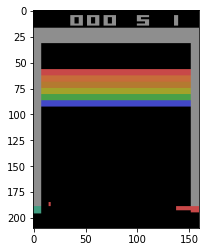

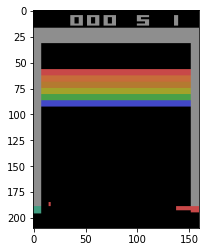

In [22]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400,300))
display.start()

env = gym.make('Breakout-v0').unwrapped
env.reset()
prev_screen = env.render(mode="rgb_array")
plt.imshow(prev_screen)
tot_r = 0
tot_r2 = 0
print(env.action_space.contains(3))

print(env.metadata)

for i in range(10):
  action = 1
  obs, reward, done, info = env.step(action)
  tot_r += reward
  action2 = env.action_space.sample()
  obs, reward2, done, info = env.step(action2)
  tot_r2 += reward2
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
  plt.pause(0.1)

  if done:
    print(tot_r)
    print(tot_r2)
    break

  # 0 : Il ne se passe rien
  # 1 : Step de descente de la balle
  # 2 : Déplacement vers la droite
  # 3 : Déplacement vers la gauche
  # Done : Only quand les 5 vies sont passées
  # Pas de reward neg lors de la perte de vie
  # Pas de reward positive lors du cassage de brique ou renvoi de la balle
  # Reward positive de 1 lorsque cassage de brique :  

# Training de l'agent

Les résultats de l'agent sont très aléatoires, ce phénomène s'explique notamment par la situation suivante: quand la barre se bloque dans un coin (droite ou gauche), sur les 5 vies de la partie, il y a très souvent une intialisation qui envoie la balle dans un de ces coins --> La bille rebondit et une reward est obtenue lorsque la brique est cassée.

Comme observé sur les phases de test l'agent a tendance à se bloquer dans un coin car il juge que c'est la stratégie qui lui donnera la meilleure reward (on peut penser que le réseau DQN est bloqué dans un minimum local ne permettant pas d'autre prise de décision). Une solution à cela serait d'augmenter la complexité d'entraînement pour forcer la descente de gradient à sortir de ce minimum local ou alors d'agir sur l'environnement en modifiant l'initialisation de la direction de la bille.

Afin de résoudre ce problème la variation de l'eps_decay peut-être une solution pour essayer de modifier la stratégie choisie par l'agent (ie prévenir l'algorithme d'apprentissage de tomber dans un minimum local). On va donc augmenter l'eps_decay.



## Training with eps_decay = 200
Le nombre de time steps est seulement dû au temps que la bille met pour descendre et aux 5 vies. 

L'algorithme n'apprend pas une statégie performante.

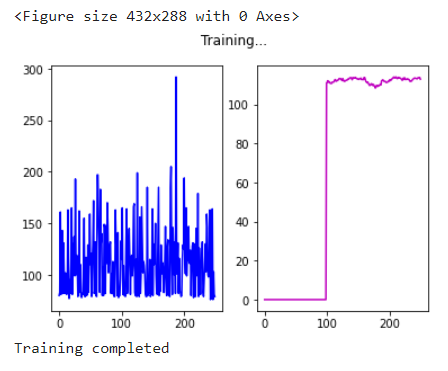

## Training with eps_decay = 10000
On observe peu de différence avec l'entrainement précédent. 

Le nombre de time steps est seulement dû au temps que la bille met pour descendre et aux 5 vies.

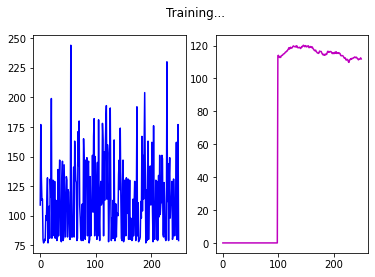

## Training with eps_decay = 10000.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

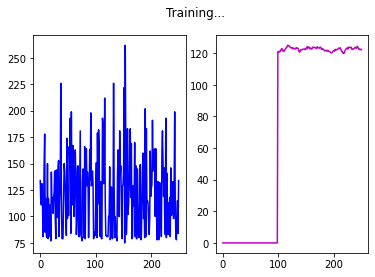

Training completed


In [23]:
env = gym.make('Breakout-v0').unwrapped
env.reset()
agent = Agent(env, num_episodes=250, num_episodes_test=1)

# Training phase
agent.train_policy_model()

# Testing de l'agent

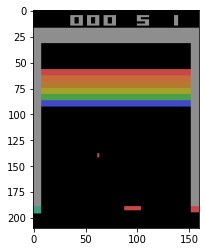

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.


TypeError: ignored

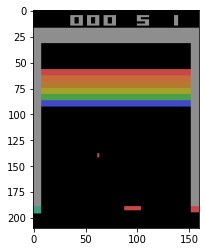

In [24]:
#Testing phase
agent.load_model()
agent.test()

In [ ]:
ipythondisplay.clear_output(wait=True)
env.close()